# Tune Hyperparameters

There are many machine learning algorithms that require *hyperparameters* (parameter values that influence training, but can't be determined from the training data itself). For example, when training a logistic regression model, you can use a *regularization rate* hyperparameter to counteract bias in the model; or when training a convolutional neural network, you can use hyperparameters like *learning rate* and *batch size* to control how weights are adjusted and how many data items are processed in a mini-batch respectively. The choice of hyperparameter values can significantly affect the performance of a trained model, or the time taken to train it; and often you need to try multiple combinations to find the optimal solution.

In this case, you'll train a classification model with two hyperparameters, but the principles apply to any kind of model you can train with Azure Machine Learning.

## Connect to your workspace

To get started, connect to your workspace.

> **Note**: If you haven't already established an authenticated session with your Azure subscription, you'll be prompted to authenticate by clicking a link, entering an authentication code, and signing into Azure.

In [1]:
import azureml.core
from azureml.core import Workspace

import logging
import os
import csv
from datetime import datetime
import pytz


from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets
import pkg_resources

import seaborn as sns
import tensorflow as tf

import matplotlib.pyplot as plt
import re
import pydot
import graphviz

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig
from azureml.core.dataset import Dataset

from azureml.pipeline.steps import AutoMLStep


# Check core SDK version number
# print("SDK version:", azureml.core.VERSION)

# Load the workspace from the saved config file
ws = Workspace.from_config()
print('Ready to use Azure ML {} to work with {}'.format(azureml.core.VERSION, ws.name))

print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep = '\n')

print("Tensorflow version: ", tf.__version__)
print("Current DateTime: ", datetime.now(pytz.timezone("America/New_York")).strftime("%m/%d/%Y %H:%M:%S"))

Ready to use Azure ML 1.41.0 to work with nahmed30-azureml-workspace
nahmed30-azureml-workspace
epe-poc-nazeer
centralus
16bc73b5-82be-47f2-b5ab-f2373344794c
Tensorflow version:  2.2.0
Current DateTime:  08/29/2022 21:18:12


In [2]:
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch

from sklearn.preprocessing import StandardScaler
from tensorflow.keras import models, layers
from keras_tuner import HyperModel, RandomSearch, Hyperband, BayesianOptimization



## Prepare data

In this lab, you'll use a dataset containing details of diabetes patients. Run the cell below to create this dataset (if it already exists, the existing version will be used)

In [3]:
from azureml.core import Dataset

# Try to load the dataset from the Workspace. Otherwise, create it from the file
# NOTE: update the key to match the dataset name
found = False
key = "UdacityPrjEmailSpamDataSet"
description_text = "Spam Detection DataSet for Udacity Capstone Proj "

dataset = None
if key in ws.datasets.keys(): 
        found = True
        dataset = ws.datasets[key] 

df = dataset.to_pandas_dataframe()
df.describe()


,v1,v2,Column3,Column4,Column5
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""",GE,"GNT:-)"""
freq,4825,30,3,2,2


## Prepare a training script

Now let's create a folder for the training script you'll use to train the model.

In [4]:
# Choose a name for the run history container in the workspace.
# NOTE: update these to match your existing experiment name
experiment_folder = 'spam_training-hyperdrive'
experiment_name = 'ml-spam-experiment-prjassign1'
project_folder = 'spam_training-hyperdrive'

os.makedirs(project_folder, exist_ok=True)

print('Project Folder is ready.')

experiment = Experiment(ws, experiment_name)
experiment

Project Folder is ready.


Name,Workspace,Report Page,Docs Page
ml-spam-experiment-prjassign1,nahmed30-azureml-workspace,Link to Azure Machine Learning studio,Link to Documentation


## Create compute

Hyperparameter tuning involves running multiple training iterations with different hyperparameter values and comparing the performance metrics of the resulting models. To do this efficiently, we'll take advantage of on-demand cloud compute and create a cluster - this will allow multiple training iterations to be run concurrently.

Use the following code to specify an Azure Machine Learning compute cluster (it will be created if it doesn't already exist).

> **Important**: Change *your-compute-cluster* to the name of your compute cluster in the code below before running it! Cluster names must be globally unique names between 2 to 16 characters in length. Valid characters are letters, digits, and the - character.

In [5]:
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget
from azureml.core.compute_target import ComputeTargetException

# NOTE: update the cluster name to match the existing cluster
# Choose a name for your CPU cluster
amlcompute_cluster_name = "cpu-cluster"

# Verify that cluster does not exist already
try:
    compute_target = ComputeTarget(workspace=ws, name=amlcompute_cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_D2_V2',# for GPU, use "STANDARD_NC6"
                                                           #vm_priority = 'lowpriority', # optional
                                                           max_nodes=4)
    compute_target = ComputeTarget.create(ws, amlcompute_cluster_name, compute_config)

compute_target.wait_for_completion(show_output=True, min_node_count = 1, timeout_in_minutes = 10)
# For a more detailed view of current AmlCompute status, use get_status().

Found existing cluster, use it.
Succeeded......................................................................................................................
AmlCompute wait for completion finished

Wait timeout has been reached
Current provisioning state of AmlCompute is "Succeeded" and current node count is "0"


> **Note**: Compute instances and clusters are based on standard Azure virtual machine images. For this exercise, the *Standard_DS11_v2* image is recommended to achieve the optimal balance of cost and performance. If your subscription has a quota that does not include this image, choose an alternative image; but bear in mind that a larger image may incur higher cost and a smaller image may not be sufficient to complete the tasks. Alternatively, ask your Azure administrator to extend your quota.

You'll need a Python environment to be hosted on the compute, so let's define that as Conda configuration file.

In [6]:
%%writefile $project_folder/hyperdrive_env.yml
name: batch_environment
dependencies:
- python
- scikit-learn
- pandas
- numpy
- pip
- pip:
  - azureml-defaults


Overwriting spam_training-hyperdrive/hyperdrive_env.yml


In [7]:
dataset.take(5).to_pandas_dataframe()

,v1,v2,Column3,Column4,Column5
0,ham,"Go until jurong point, crazy.. Available only ...",None,None,None
1,ham,Ok lar... Joking wif u oni...,None,None,None
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,None,None,None
3,ham,U dun say so early hor... U c already then say...,None,None,None
4,ham,"Nah I don't think he goes to usf, he lives aro...",None,None,None


In [16]:
df.head()

,v1,v2,Column3,Column4,Column5
0,ham,"Go until jurong point, crazy.. Available only ...",None,None,None
1,ham,Ok lar... Joking wif u oni...,None,None,None
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,None,None,None
3,ham,U dun say so early hor... U c already then say...,None,None,None
4,ham,"Nah I don't think he goes to usf, he lives aro...",None,None,None


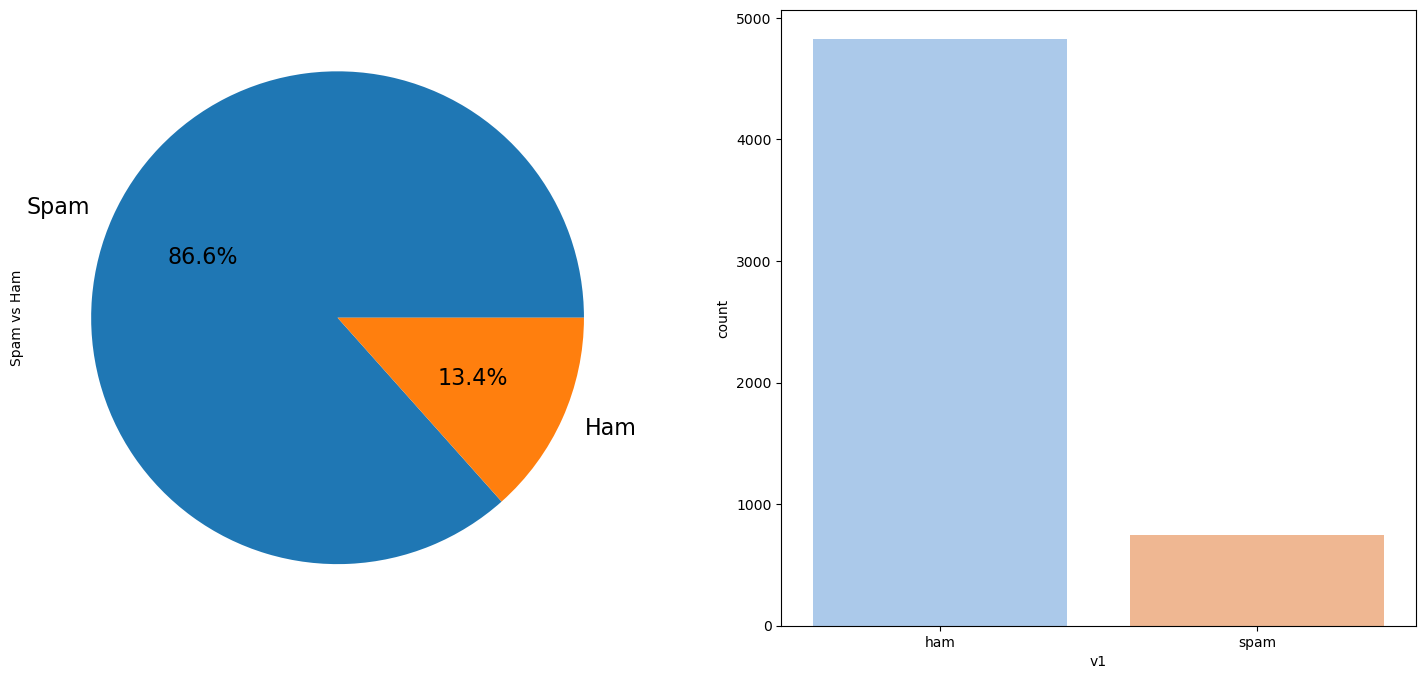

In [8]:
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
df.v1.value_counts().plot(kind="pie",
                                           fontsize=16,
                                           labels=["Spam", "Ham"],
                                           ylabel="Spam vs Ham",
                                           autopct='%1.1f%%');

plt.subplot(1, 2, 2)
sns.countplot(x="v1",data=df, palette="pastel")
plt.show()

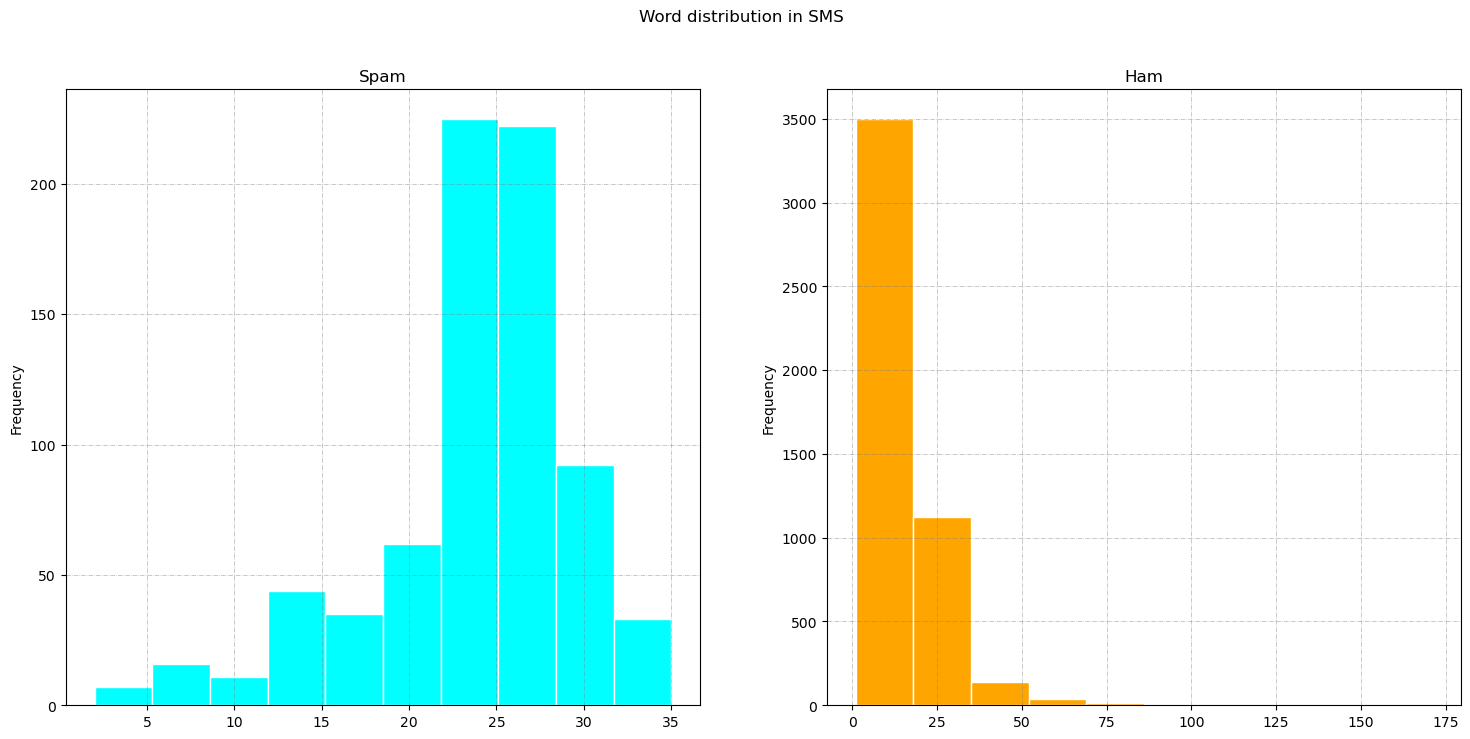

In [9]:
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
ax1 = df.query("v1=='spam'").v2.map(lambda x: len(x.split())).plot(kind="hist",
                                                                    color="cyan",
                                                                    title="Spam",
                                                                    edgecolor='white');
plt.subplot(1, 2, 2)
ax2 = df.query("v1=='ham'").v2.map(lambda x: len(x.split())).plot(kind="hist",
                                                                    color="orange",
                                                                    title="Ham",
                                                                    edgecolor='white');

ax1.grid(visible = True, color ='grey',linestyle ='-.', linewidth = 0.5,alpha = 0.6)
ax2.grid(visible = True, color ='grey',linestyle ='-.', linewidth = 0.5,alpha = 0.6)
plt.suptitle('Word distribution in SMS')
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


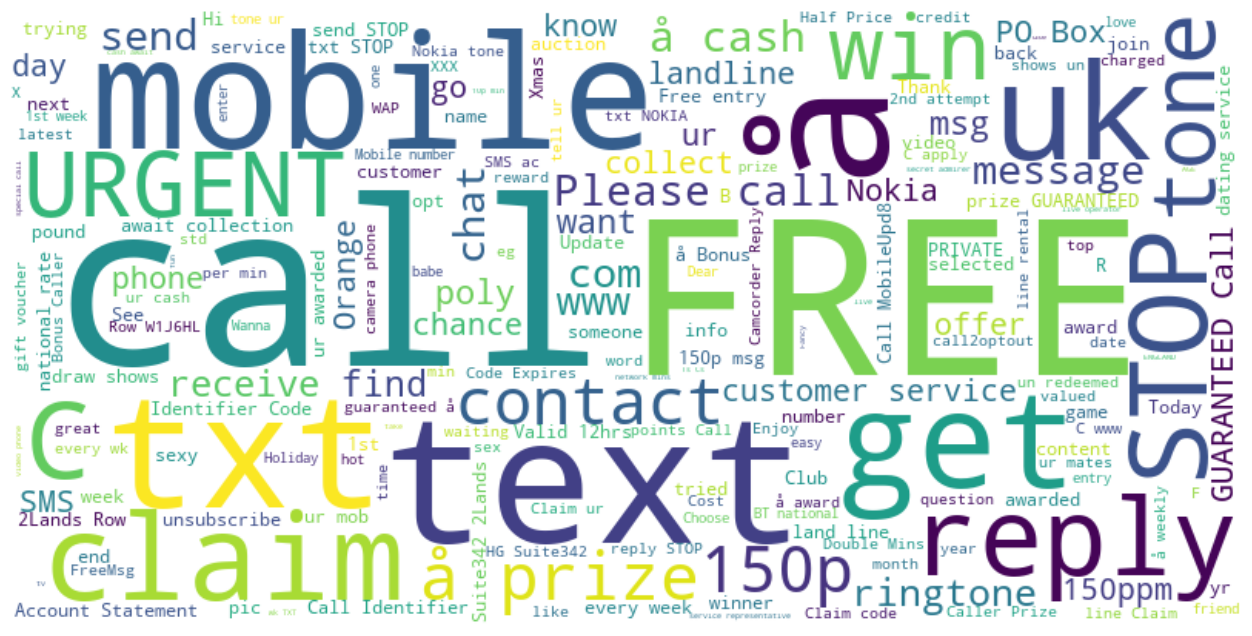

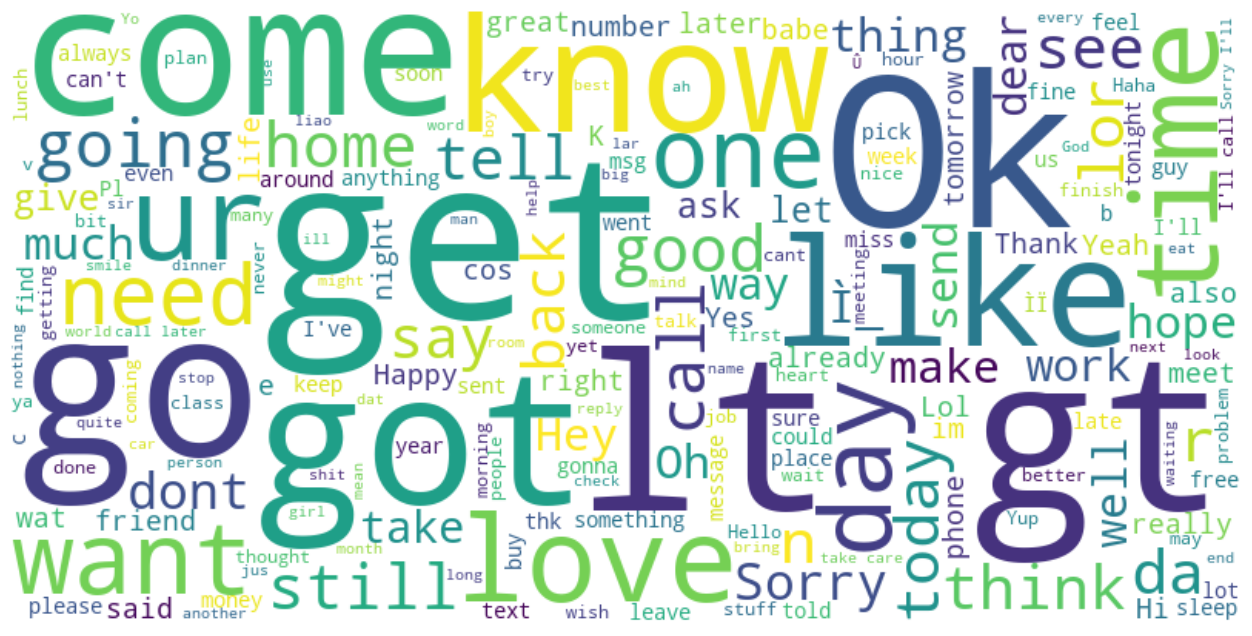

In [10]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud
stop_words= set(stopwords.words("english"))

stop_words.update(['https', 'http', 'amp', 'CO', 't', 'u', 'new', "I'm", "would"])

wc = WordCloud(width=800,
               height=400,
               max_words=200,
               stopwords=stop_words,
               background_color='white',
               max_font_size=150)
spam = df.query("v1=='spam'").v2.str.cat(sep=" ")

ham = df.query("v1=='ham'").v2.str.cat(sep=" ")

print('\n\nWord Cloud for Spam messages\n\n')
wc.generate(spam)
plt.figure(figsize=(16, 8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

print('\n\nWord Cloud for Ham messages\n\n')
wc.generate(ham)
plt.figure(figsize=(16, 8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [11]:
df = df.replace('spam', 1)
df = df.replace('ham', 0)
df

,v1,v2,Column3,Column4,Column5
0,0,"Go until jurong point, crazy.. Available only ...",None,None,None
1,0,Ok lar... Joking wif u oni...,None,None,None
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,None,None,None
3,0,U dun say so early hor... U c already then say...,None,None,None
4,0,"Nah I don't think he goes to usf, he lives aro...",None,None,None
...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,None,None,None
5568,0,Will Ì_ b going to esplanade fr home?,None,None,None
5569,0,"Pity, * was in mood for that. So...any other s...",None,None,None
5570,0,The guy did some bitching but I acted like i'd...,None,None,None


In [12]:
def cleanText(text):
    whitespace = re.compile(r"\s+")
    web_address = re.compile(r"(?i)http(s):\/\/[a-z0-9.~_\-\/]+")
    user = re.compile(r"(?i)@[a-z0-9_]+")
    text = text.replace('.', '')
    text = whitespace.sub(' ', text)
    text = web_address.sub('', text)
    text = user.sub('', text)
    text = re.sub(r"\[[^()]*\]", "", text)
    text = re.sub(r"\d+", "", text)
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r"(?:@\S*|#\S*|http(?=.*://)\S*)", "", text)
    return text.lower()

df.v2 = [cleanText(item) for item in df.v2]
df

,v1,v2,Column3,Column4,Column5
0,0,go until jurong point crazy available only in ...,None,None,None
1,0,ok lar joking wif u oni,None,None,None
2,1,free entry in a wkly comp to win fa cup final...,None,None,None
3,0,u dun say so early hor u c already then say,None,None,None
4,0,nah i dont think he goes to usf he lives aroun...,None,None,None
...,...,...,...,...,...
5567,1,this is the nd time we have tried contact u u...,None,None,None
5568,0,will ì_ b going to esplanade fr home,None,None,None
5569,0,pity was in mood for that soany other suggest...,None,None,None
5570,0,the guy did some bitching but i acted like id ...,None,None,None


In [13]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.oov_token = '<oovToken>'
tokenizer.fit_on_texts(df.v2)
vocab = tokenizer.word_index
vocabCount = len(vocab)+1

vocabCount

8606

In [14]:
SPLIT = 5000

xTrain = tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(df.v2.to_numpy()), padding='pre', maxlen=171)
yTrain = df.v1.to_numpy()
dim = xTrain.shape[1]
xTest = xTrain[SPLIT:]
yTest = yTrain[SPLIT:]

xTrain = xTrain[:SPLIT]
yTrain = yTrain[:SPLIT]

xTrain.shape, yTrain.shape, xTest.shape, yTest.shape

((5000, 171), (5000,), (572, 171), (572,))

**Straight to hyperparameter tuning **

In [15]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=vocabCount+1, output_dim=64, input_length=dim))
model.add(tf.keras.layers.GlobalAveragePooling1D())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 171, 64)           550848    
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 557,121
Trainable params: 557,121
Non-trainable params: 0
_________________________________________________________________


**Building the Hypermodel**

In [17]:
def build_myhm(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(input_dim=vocabCount+1, output_dim=64, input_length=dim))
    model.add(tf.keras.layers.GlobalAveragePooling1D())
    units_l1=hp.Int('units', min_value=8,max_value=128, step=8)
    model.add(tf.keras.layers.Dense(units=units_l1, activation='relu', input_dim=8))
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    optim=hp.Choice('optimizer', values = ['adam', 'sgd', 'rmsprop', 'adadelta'])

    model.compile( optim, loss='binary_crossentropy', metrics=['accuracy'])

    model.summary()

    return model


In [18]:
from keras_tuner import RandomSearch
from keras_tuner import Objective

tuner =  RandomSearch(build_myhm,
                      objective='val_accuracy',
                      max_trials=5,
                      project_name='spam_randomsearch',
                      directory='spam_randomsearch_dir',
                      overwrite=True
                    )

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 171, 64)           550848    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                288       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 551,689
Trainable params: 551,689
Non-trainable params: 0
_________________________________________________________________


In [ ]:

# xTrain.shape, yTrain.shape, xTest.shape, yTest.shape
tuner.search(xTrain, yTrain, batch_size=32, epochs=10, validation_data=(xTest, yTest))

157/157 [==============================] - 1s 4ms/step - loss: 0.0085 - accuracy: 0.9984 - val_loss: 0.0414 - val_accuracy: 0.9860
Trial 5 Complete [00h 00m 10s]
val_accuracy: 0.9877622127532959

Best val_accuracy So Far: 0.9895104765892029
Total elapsed time: 00h 00m 43s
INFO:tensorflow:Oracle triggered exit


In [20]:
tuner.get_best_hyperparameters()[0].values

{'units': 48, 'optimizer': 'adam'}

In [21]:
best_model=tuner.get_best_models(num_models=1)[0]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 171, 64)           550848    
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 48)                3120      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1568      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 555,569
Trainable params: 555,569
Non-trainable params: 0
_________________________________________________________________


In [22]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 171, 64)           550848    
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 48)                3120      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1568      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 555,569
Trainable params: 555,569
Non-trainable params: 0
_________________________________________________________________


In [23]:
best_model.fit(xTrain, yTrain, batch_size=32, epochs=100, initial_epoch=6, validation_data=(xTest, yTest))

Epoch 7/100
157/157 [==============================] - 1s 4ms/step - loss: 0.0136 - accuracy: 0.9958 - val_loss: 0.0339 - val_accuracy: 0.9895
Epoch 8/100
157/157 [==============================] - 1s 4ms/step - loss: 0.0095 - accuracy: 0.9976 - val_loss: 0.0384 - val_accuracy: 0.9860
Epoch 9/100
157/157 [==============================] - 1s 4ms/step - loss: 0.0080 - accuracy: 0.9982 - val_loss: 0.0400 - val_accuracy: 0.9860
Epoch 10/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0077 - accuracy: 0.9982 - val_loss: 0.0363 - val_accuracy: 0.9878
Epoch 11/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0078 - accuracy: 0.9980 - val_loss: 0.0389 - val_accuracy: 0.9843
Epoch 12/100
157/157 [==============================] - 1s 4ms/step -

In [86]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 171, 64)           550848    
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 40)                2600      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1312      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 554,793
Trainable params: 554,793
Non-trainable params: 0
_________________________________________________________________


In [24]:
best_model.evaluate(xTest, yTest)

18/18 [==============================] - 0s 984us/step - loss: 0.1004 - accuracy: 0.9860


[0.10042763501405716, 0.9860140085220337]

In [25]:
text = "Congratulations, you have won a 10000 dollars lottery. Please give your bank details to claim the money"
processedText = cleanText(text)
#print(processedText)
finalText = tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences([processedText]), padding='pre', maxlen=171)
prediction = best_model.predict(finalText)
print("prediction shape", prediction.shape)
print(prediction)

print(np.int(np.rint(prediction[0,0])))

prediction shape (1, 1)
[[0.9999994]]
1


In [26]:
text = "I'll meet you at nariman point tomorrow"
processedText = cleanText(text)
#print(processedText)
finalText = tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences([processedText]), padding='pre', maxlen=171)
prediction = best_model.predict(finalText)
print("prediction shape", prediction.shape)
print(prediction)
print(np.int(np.rint(prediction[0,0])))

prediction shape (1, 1)
[[3.6531355e-07]]
0


In [27]:
text = "You won $100 click link below to collect"
processedText = cleanText(text)
#print(processedText)
finalText = tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences([processedText]), padding='pre', maxlen=171)
prediction = best_model.predict(finalText)
print("prediction shape", prediction.shape)
print(prediction)
print(np.int(np.rint(prediction[0,0])))

prediction shape (1, 1)
[[0.99999547]]
1


## Run a hyperparameter tuning experiment

Azure Machine Learning includes a hyperparameter tuning capability through *hyperdrive* experiments. These experiments launch multiple child runs, each with a different hyperparameter combination. The run producing the best model (as determined by the logged target performance metric for which you want to optimize) can be identified, and its trained model selected for registration and deployment.

> **Note**: In this example, we aren't specifying an early stopping policy. Such a policy is only relevant if the training script performs multiple training iterations, logging the primary metric for each iteration. This approach is typically employed when training deep neural network models over multiple *epochs*.

https://www.tensorflow.org/tutorials/keras/keras_tuner

In [ ]:
import keras_tuner as kt

In [28]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [30]:
tuner.search(xTrain, yTrain, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]



INFO:tensorflow:Oracle triggered exit


In [ ]:
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

In [32]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
modelhp = tuner.hypermodel.build(best_hps)
history = modelhp.fit(xTrain, yTrain, epochs=50, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 171, 64)           550848    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 48)                3120      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1568      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 555,569
Trainable params: 555,569
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
125/125 [==============================] - 1s 5ms/step - loss: 0.4510 - accuracy: 0.8590 - val_loss: 0.

In [33]:
eval_result = modelhp.evaluate(xTest, yTest)
print("[test loss, test accuracy]:", eval_result)

18/18 [==============================] - 0s 1ms/step - loss: 0.0922 - accuracy: 0.9860
[test loss, test accuracy]: [0.0922052338719368, 0.9860140085220337]


In [35]:
text = "You won $100 click link below to collect"
processedText = cleanText(text)
#print(processedText)
finalText = tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences([processedText]), padding='pre', maxlen=171)
prediction = modelhp.predict(finalText)
print("prediction shape", prediction.shape)
print(prediction)
print(prediction[0,0])
print(np.int(np.rint(prediction[0,0])))

prediction shape (1, 1)
[[0.9982212]]
0.9982212
1


In [36]:
text = "I'll meet you at nariman point tomorrow"
processedText = cleanText(text)
#print(processedText)
finalText = tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences([processedText]), padding='pre', maxlen=171)
prediction = modelhp.predict(finalText)
print("prediction shape", prediction.shape)
print(prediction)
print(np.int(np.rint(prediction[0,0])))

prediction shape (1, 1)
[[8.2998895e-06]]
0


Now that you've found the best run, you can register the model it trained.

> **More Information**: For more information about Hyperdrive, see the [Azure ML documentation](https://docs.microsoft.com/azure/machine-learning/how-to-tune-hyperparameters).